In [17]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account

# from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report
from google.cloud import aiplatform

# Reference
https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [18]:
print(tf.__version__)

2.15.1


In [19]:
table_id='test_incident'
#table_id='validation_incident'
#table_id='new_incident'
#table_id='train_incident'

ENDPOINT_ID="2469916532356939776"
MODEL_ID="2354195132556771328"

isLocalModel=True
isBQToCSV=False
localMapFile=True
gs_store_class="demo2-tf-incident-pongthorn"
gs_model_path="gs://demo2-tf-incident-pongthorn/demo_model_tf"

local_model_path='model'
# ! gsutil -m cp -r "gs://demo2-tf-incident-pongthorn/demo_model_tf" .


modelFile_endPoint=2
#1=local(dev)/gcs(clound function) and 2=endpoint on vertext

# projectId='smart-data-ml'
projectId='pongthorn'
dataset_id='SMartML'
REGION="asia-southeast1"

n_sample_run=0

# mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
bqclient= bigquery.Client(project=projectId)

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='csv_dataset/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'csv_dataset/Prediction_{table_id}.csv'


In [20]:
if isBQToCSV:
    
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    
  
if n_sample_run>0:
 dfNewData=dfNewData.tail(n_sample_run)
print(dfNewData.info())
dfNewData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         427 non-null    int64  
 1   severity_id                427 non-null    Int64  
 2   severity_name              427 non-null    object 
 3   sla                        427 non-null    object 
 4   product_type               427 non-null    object 
 5   brand                      427 non-null    object 
 6   service_type               427 non-null    object 
 7   incident_type              427 non-null    object 
 8   open_to_close_hour         427 non-null    float64
 9   response_to_resolved_hour  427 non-null    float64
 10  severity                   427 non-null    Int64  
dtypes: Int64(2), float64(2), int64(1), object(6)
memory usage: 37.7+ KB
None


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
0,1,2,Major,24x7 2Hrs Response Time,Switch,HSM,Incident,Other Failure,2.000000,2.000000,2
1,2,2,Major,24x7 4Hrs Response Time,Switch,Broadcom,Request,General Incident,37.583333,1.000000,2
2,3,2,Major,24x7 4Hrs Response Time,Software,Nutanix,Incident,General Incident,3.383333,3.216667,2
3,4,3,Minor,24x7 4Hrs Response Time,Other,APC,Incident,General Incident,20.033333,6.000000,1
4,5,3,Minor,24x7 6Hrs Resolution Time,Software,CIMCO-CMMS,Incident,Software,317.550000,315.000000,1



# Load and Map Data Test

In [21]:

mapping_file="incident_severity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket(gs_store_class)
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localMapFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)



{'Cosmetic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [22]:
if  table_id=='new_incident':
   dfNewData['severity']= dfNewData['severity_name'].map(map_sevirity_to_class)
else:
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})

if 'id' not in dfNewData.columns.to_list():
    dfNewData=dfNewData.reset_index(drop=True)
    dfNewData = dfNewData.reset_index(level=0)
    dfNewData.rename(columns={"index": "id"},inplace=True)
    dfNewData['id']=dfNewData['id']+1
print(f"Table: {table_id}")
print(filePath) 
print(dfNewData.info())

dfNewData.to_csv(f"{table_id}.csv",index=False)

Table: test_incident
csv_dataset/Prediction_test_incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         427 non-null    int64  
 1   severity_id                427 non-null    Int64  
 2   severity_name              427 non-null    object 
 3   sla                        427 non-null    object 
 4   product_type               427 non-null    object 
 5   brand                      427 non-null    object 
 6   service_type               427 non-null    object 
 7   incident_type              427 non-null    object 
 8   open_to_close_hour         427 non-null    float64
 9   response_to_resolved_hour  427 non-null    float64
 10  severity                   427 non-null    Int64  
dtypes: Int64(2), float64(2), int64(1), object(6)
memory usage: 37.7+ KB
None


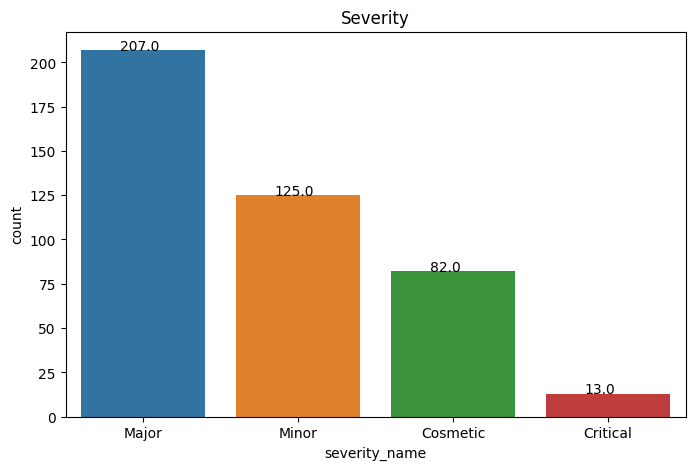

In [23]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

# Load Model from Directory to Predict

In [43]:
if  isLocalModel: # Window Enviroment
    PATH_FOLDER_ARTIFACTS=local_model_path   
else: # For running on Vertex AI Notebook t
    PATH_FOLDER_ARTIFACTS=gs_model_path
print(f"Load from {PATH_FOLDER_ARTIFACTS}")
model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)   
print(model.tensorflow_version)
# print(model.summary())

Load from model
2.15.1


# Predict Model

In [45]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

    # print(model.summary())

for  row_dict in dfNewData.to_dict(orient="records"):
      incident_id=row_dict['id']
      # print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 

      for key_removed in unUsedColtoPredict:
       row_dict.pop(key_removed)
      # print(row_dict)  

      input_tensor = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}
      predictionResult = model.predict(input_tensor)

      prob = tf.nn.softmax(predictionResult)
      prob_pct=(100 * prob)  
      _class = tf.argmax(predictionResult,-1).numpy()[0]

      pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )

      # print(input_tensor)    
      # print(f"{prob_pct} %   as {_class}")     
      # print("======================================================================================")

dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
dfPredictData=dfPredictData.drop(columns=['_id'])
dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]
print("Predicted all data completely")


1/1 [==============================] - 0s 24ms/step
Predicted all data completely


In [46]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,1,1,2,Major
1,2,0,2,Major
2,3,1,2,Major
3,4,1,1,Minor
4,5,2,1,Minor
...,...,...,...,...
422,423,1,1,Minor
423,424,1,1,Minor
424,425,1,1,Minor
425,426,0,0,Cosmetic


# Classification Rerport

In [47]:
def make_classification_report(dfResult):
    print(dfResult.tail())
    className=list(set().union(list(dfResult['severity'].unique()),list(dfResult['_predict_severity'].unique())))
    actualClass=[  f'actual-{x}' for x in  className]
    predictedlClass=[  f'predcited-{x}' for x in className]

    y_true=list(dfResult['severity'])
    y_pred=list(dfResult['_predict_severity'])
    cnf_matrix = confusion_matrix(y_true,y_pred)

    # #index=actual , column=prediction
    cm_df = pd.DataFrame(cnf_matrix,
                         index = actualClass, 
                         columns = predictedlClass)
    print(cm_df)

    print(classification_report(y_true, y_pred, labels=className))

In [48]:
make_classification_report(dfPredictData)

      id _predict_severity  severity severity_name
422  423                 1         1         Minor
423  424                 1         1         Minor
424  425                 1         1         Minor
425  426                 0         0      Cosmetic
426  427                 0         0      Cosmetic
          predcited-0  predcited-1  predcited-2  predcited-3
actual-0           71            6            5            0
actual-1           12           80           33            0
actual-2            7           33          167            0
actual-3            0            0           13            0
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        82
           1       0.67      0.64      0.66       125
           2       0.77      0.81      0.79       207
           3       0.00      0.00      0.00        13

    accuracy                           0.74       427
   macro avg       0.56      0.58      0.57       427
weighted 

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
